# Lab 01 : Video Classification - solution

The goal is to implement three architectures (late fusion 2D-CNN, early fusion 2D-CNN, 3D-CNN) that classifies video sequences.</br>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture14'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

In [3]:
#device= torch.device("cuda")
device= torch.device("cpu")
print(device)

cpu


### Generate the dataset 

In [4]:
# Libraries
#from torchvision.transforms import ToTensor
#from PIL import Image
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


torch.Size([3, 10, 28, 28])
torch.Size([3])


<IPython.core.display.Javascript object>


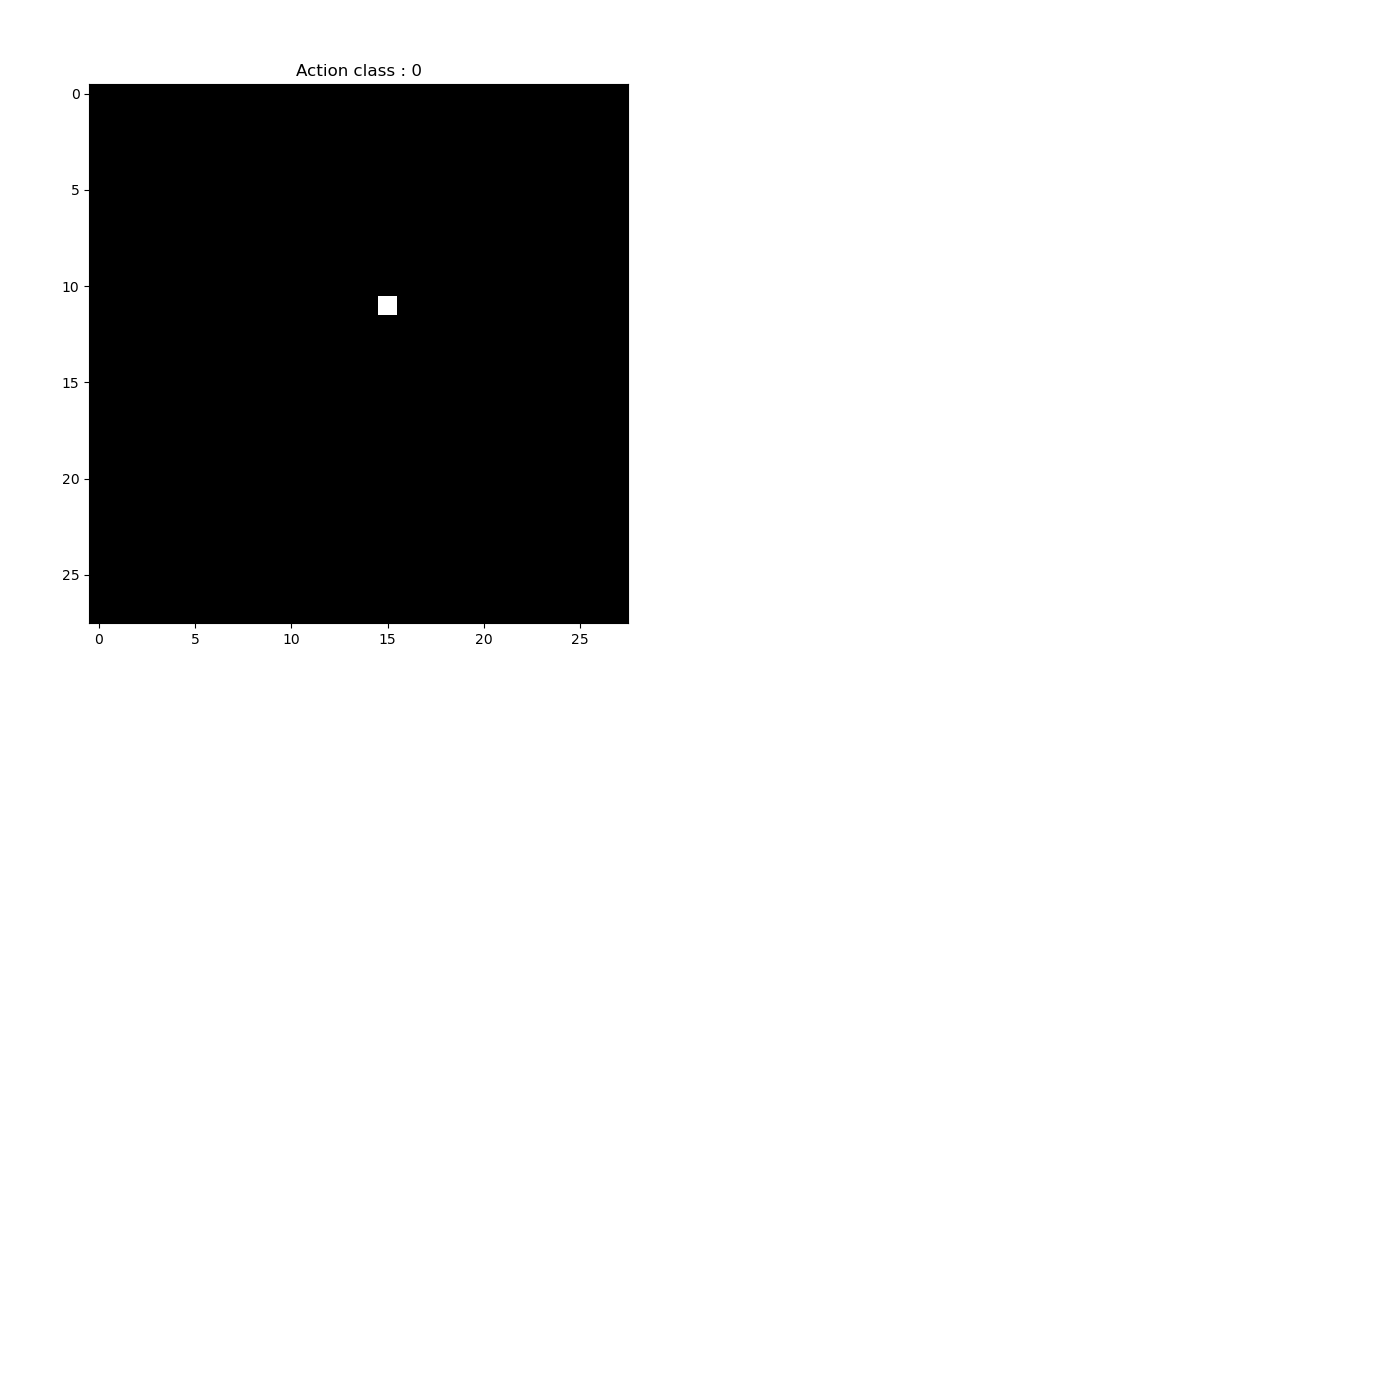

<IPython.core.display.Javascript object>


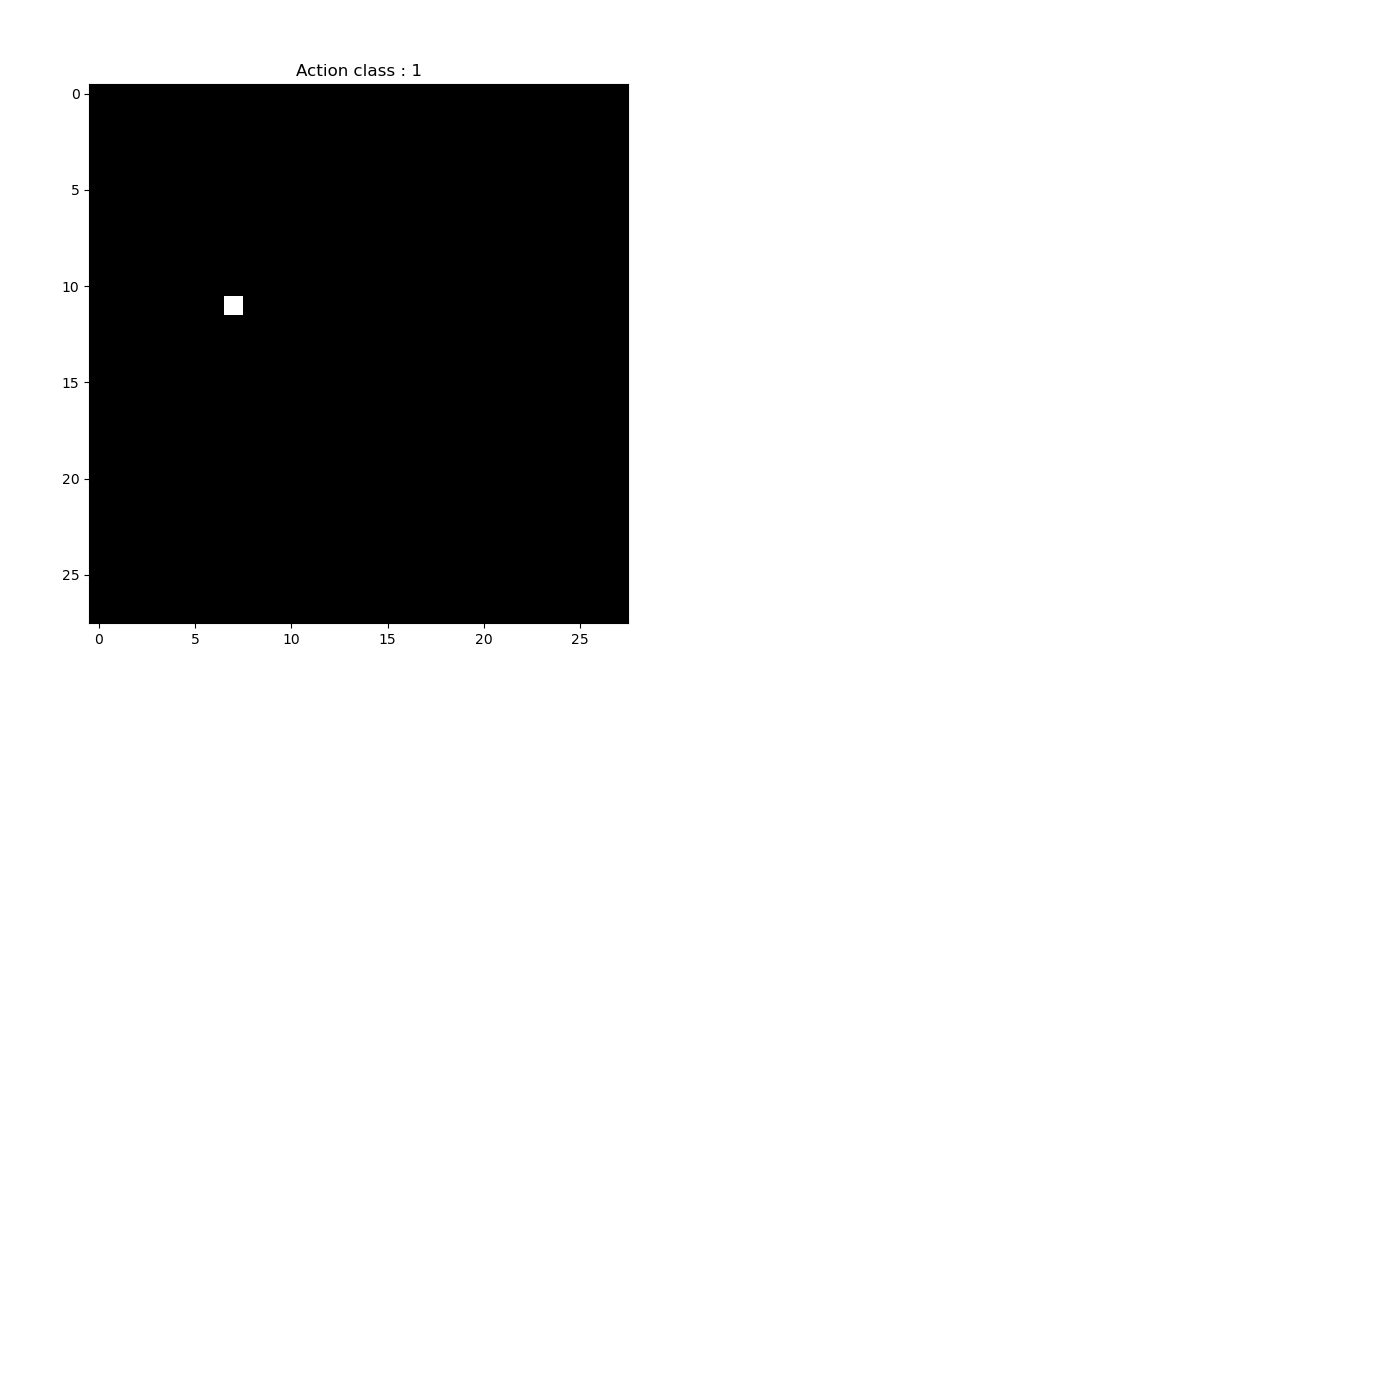

<IPython.core.display.Javascript object>


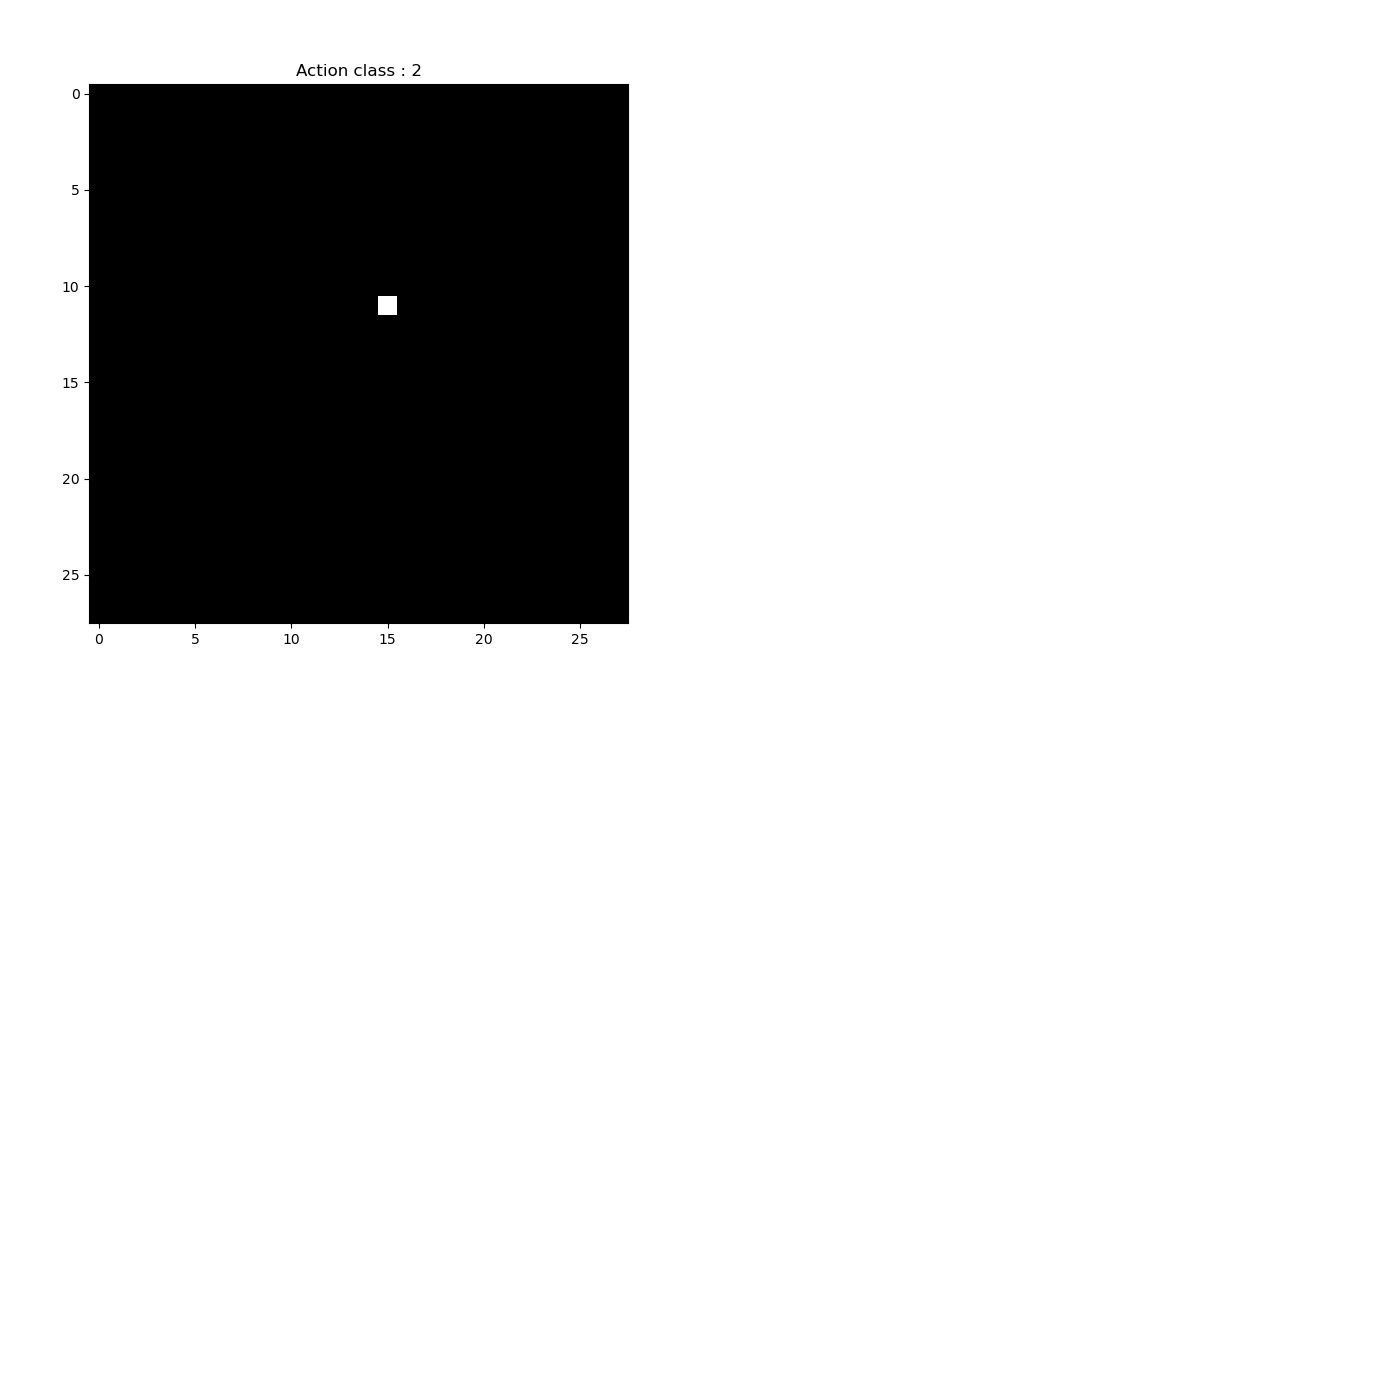

<IPython.core.display.Javascript object>


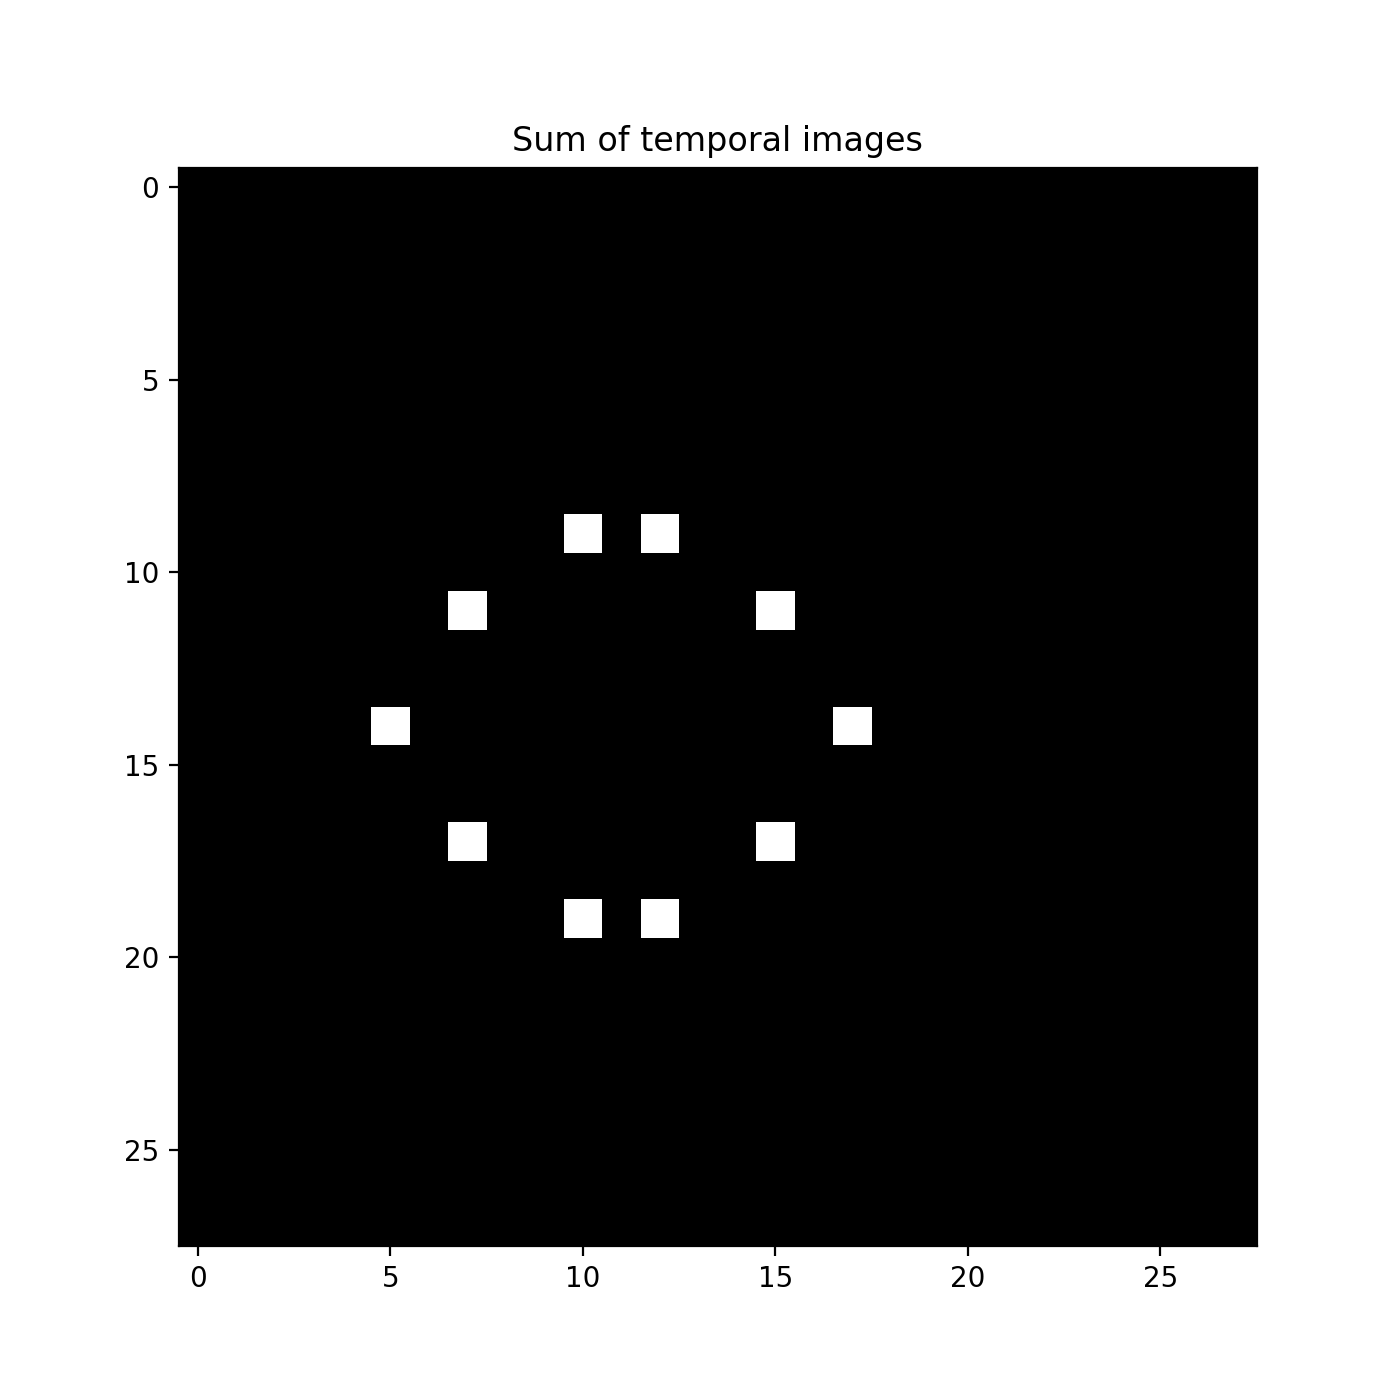

In [5]:
# Global constants
# im_size = image size  
# nb_actions = number of action classes
# nb_steps = number of time steps
# batch_size = nb_actions * nb_steps
# radius_actions = radius of the circular movement 
im_size = 28 
nb_actions = 3
nb_steps = 10
batch_size = nb_actions * nb_steps
radius_actions = 6

# Function that generate a batch of training data
def generate_batch_data(im_size, batch_size, nb_actions, radius_actions, nb_steps):
    batch_videos = torch.zeros(nb_actions,nb_steps,im_size,im_size)
    batch_labels = torch.zeros(nb_actions)
    
    offset = radius_actions
    coord_objects = torch.LongTensor(2).random_(-offset,offset)
    
    # class action 0
    action_class = 0
    video = torch.zeros(nb_steps,im_size,im_size) 
    for k in range(nb_steps):        
        y = im_size//2 + (radius_actions* torch.sin(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[1]
        x = im_size//2 + (radius_actions* torch.cos(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[0]
        video[k,y,x] = 1.0
    batch_videos[action_class,:,:,:] = video
    batch_labels[action_class] = action_class
    # class action 1
    action_class = 1
    video = torch.zeros(nb_steps,im_size,im_size) 
    for k in range(nb_steps//2+1):        
        y = im_size//2 + (radius_actions* torch.sin(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[1]
        x = im_size//2 + (radius_actions* torch.cos(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[0]
        video[k,y,x] = 1.0
    for k in range(nb_steps-1,nb_steps//2,-1):        
        y = im_size//2 + (radius_actions* torch.sin(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[1]
        x = im_size//2 + (radius_actions* torch.cos(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[0]
        video[nb_steps//2+nb_steps-k,y,x] = 1.0
    batch_videos[action_class,:,:,:] = video
    batch_labels[action_class] = action_class   
    # class action 2
    action_class = 2
    video = torch.zeros(nb_steps,im_size,im_size) 
    for k in range(nb_steps//2,-1,-1):  
        y = im_size//2 + (radius_actions* torch.sin(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[1]
        x = im_size//2 + (radius_actions* torch.cos(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[0]
        video[nb_steps//2-k,y,x] = 1.0
    for k in range(nb_steps//2+1,nb_steps):        
        y = im_size//2 + (radius_actions* torch.sin(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[1]
        x = im_size//2 + (radius_actions* torch.cos(torch.tensor(k*2*3.1415/nb_steps))).long() + coord_objects[0]
        video[k,y,x] = 1.0
    batch_videos[action_class,:,:,:] = video
    batch_labels[action_class] = action_class  
    return batch_videos, batch_labels

# Plot a mini-batch of images
batch_videos, batch_labels = generate_batch_data(im_size, batch_size, nb_actions, radius_actions, nb_steps)
print(batch_videos.size())
print(batch_labels.size())
for a in range(nb_actions):
    fig = plt.figure(1,figsize=(7,7))
    plt.show(block=False)
    for k in range(nb_steps):
        plt.imshow(batch_videos[a,k,:,:], cmap='gray')
        plt.title('Action class : ' + str(a) )
        fig.canvas.draw()
        time.sleep(0.15)
    plt.close()
fig = plt.figure(1,figsize=(7,7))
plt.show(block=False)
sum_images = torch.zeros(im_size,im_size)
for t in range(nb_steps):
    sum_images = sum_images + batch_videos[a,t,:,:]
plt.imshow(sum_images, cmap='gray')
plt.title('Sum of temporal images')
fig.canvas.draw()


In [14]:
# Define the video classification network architecture
class videoNN(nn.Module):
    
    def __init__(self, type_videocnn):
        super(videoNN, self).__init__()
        # Hyper-parameters
        self.type_videocnn = type_videocnn
        hidden_dim = 50
        # Single-frame/late fusion 2D-CNN
        if type_videocnn == 'late_fusion':
            # conv layer
            # COMPLETE HERE
            self.conv1 = nn.Conv2d(1,  hidden_dim,  kernel_size=3, padding=1) #  1x28x28 --> hidden_dimx28x28 
            # Classification layer for average pooling over space and time
            #self.linear_class = nn.Linear(hidden_dim,  nb_actions, bias=True) #  hidden_dim --> nb_actions
            # Classification layer from flattened conv features
            # COMPLETE HERE
            self.linear_class = nn.Linear(hidden_dim*nb_steps*im_size*im_size, nb_actions, bias=True) #  hidden_dim*nb_steps*im_size*im_size --> nb_actions
        # Early fusion 2D-CNN
        if type_videocnn == 'early_fusion':
            # conv layer
            # COMPLETE HERE
            self.conv1 = nn.Conv2d(nb_steps, hidden_dim,  kernel_size=3, padding=1) #  nb_stepsx28x28 --> hidden_dimx28x28 
            # Classification layer from flattened conv features
            # COMPLETE HERE
            self.linear_class = nn.Linear(hidden_dim*im_size*im_size,  nb_actions, bias=True) #  hidden_dim --> nb_actions
        # 3D-CNN
        if type_videocnn == '3d_cnn':
            # conv layer
            # COMPLETE HERE
            self.conv1 = nn.Conv3d(1, hidden_dim,  kernel_size=3, padding=1) #  1xnb_stepsx28x28 --> hidden_dimxnb_stepsx28x28 
            # Classification layer from flattened conv features
            # COMPLETE HERE
            self.linear_class = nn.Linear(hidden_dim*nb_steps*im_size*im_size, nb_actions, bias=True) #  hidden_dim*nb_steps*im_size*im_size --> nb_actions
        
    def forward(self, x): 
        # Single-frame/late fusion 2D-CNN
        if self.type_videocnn == 'late_fusion':
            # Conv2D for each time frame independently
            # COMPLETE HERE
            x_seq = []
            for t in range(nb_steps):
                x_seq.append( self.conv1(x[:,t,:,:].unsqueeze(1)) )
            x = torch.stack(x_seq,dim=1) # [batch_size, nb_steps, hidden_dim, im_size, im_size] = [3, 10, 50, 28, 28]
            x = torch.relu(x)
            # Average pooling over space and time
            #x = x.mean(dim=4).mean(dim=3).mean(dim=1) # [batch_size, hidden_dim] = [3, 50]
            # Flattening conv features 
            x = x.view(nb_actions,-1) # 
            # Classification layer
            scores_action_class = self.linear_class(x) # [batch_size, nb_actions] = [3, 3]
        # Early fusion 2D-CNN
        if self.type_videocnn == 'early_fusion':
            # Conv2D for concatenated frames
            # COMPLETE HERE
            x = self.conv1(x) # [3, 50, 28, 28]
            x = torch.relu(x)
            # Flattening conv features 
            x = x.view(nb_actions,-1) # [batch_size, hidden_dim*im_size*im_size] = [3, 39200]
            # Classification layer
            scores_action_class = self.linear_class(x) # [batch_size, nb_actions] = [3, 3]
        # 3D-CNN
        if self.type_videocnn == '3d_cnn':
            # Conv3D for volume time x space
            # COMPLETE HERE
            x = self.conv1(x.unsqueeze(dim=1)) # [3, 50, 10, 28, 28]
            x = torch.relu(x)
            # Flattening conv features 
            x = x.view(nb_actions,-1) # [batch_size, nb_steps*hidden_dim*im_size*im_size] = [3, 392000]
            # Classification layer
            scores_action_class = self.linear_class(x) # [batch_size, nb_actions] = [3, 3]
        return scores_action_class
    
# Instantiate the network
type_videocnn = 'late_fusion'
#type_videocnn = 'early_fusion'
#type_videocnn = '3d_cnn'
net = videoNN(type_videocnn)
net = net.to(device)
print(net)
utils.display_num_param(net) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
batch_videos, batch_labels = generate_batch_data(im_size, batch_size, nb_actions, radius_actions, nb_steps)
print(batch_videos.size())
print(batch_labels.size())
optimizer.zero_grad()
scores_action_class = net(batch_videos) # [batch_size, nb_actions] = [3, 3]
batch_labels = batch_labels.long() # [batch_size] = [3]
# loss
loss = nn.CrossEntropyLoss()(scores_action_class, batch_labels)
loss.backward()
optimizer.step()


videoNN(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_class): Linear(in_features=392000, out_features=3, bias=True)
)
There are 1176503 (1.18 million) parameters in this neural network
torch.Size([3, 10, 28, 28])
torch.Size([3])


In [20]:
# Training loop
type_videocnn = 'late_fusion'
#type_videocnn = 'early_fusion'
#type_videocnn = '3d_cnn'
print('Architecture : ',type_videocnn)
net = videoNN(type_videocnn)
net = net.to(device)
utils.display_num_param(net) 

# Optimizer
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)

# Number of mini-batches per epoch
nb_batch = 25

start=time.time()
for epoch in range(10):

    running_loss = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        batch_videos, batch_labels = generate_batch_data(im_size, batch_size, nb_actions, radius_actions, nb_steps)
        optimizer.zero_grad()
        scores_action_class = net(batch_videos) # [batch_size, nb_actions] = [3, 3]
        batch_labels = batch_labels.long() # [batch_size] = [3]
        # loss
        loss = nn.CrossEntropyLoss()(scores_action_class, batch_labels)
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )
    

Architecture :  early_fusion
There are 122153 (0.12 million) parameters in this neural network
epoch= 0 	 time= 0.002055982748667399 min 	 lr= 0.001 	 loss= 1.1887060070037843
epoch= 1 	 time= 0.0035118818283081054 min 	 lr= 0.001 	 loss= 1.0683468580245972
epoch= 2 	 time= 0.005010517438252767 min 	 lr= 0.001 	 loss= 0.9930613732337952
epoch= 3 	 time= 0.0063806653022766115 min 	 lr= 0.001 	 loss= 0.9186599230766297
epoch= 4 	 time= 0.007829399903615315 min 	 lr= 0.001 	 loss= 0.7527629113197327
epoch= 5 	 time= 0.009294851620992025 min 	 lr= 0.001 	 loss= 0.677265659570694
epoch= 6 	 time= 0.010785682996114095 min 	 lr= 0.001 	 loss= 0.4961965012550354
epoch= 7 	 time= 0.012482619285583496 min 	 lr= 0.001 	 loss= 0.3819081765413284
epoch= 8 	 time= 0.013893568515777588 min 	 lr= 0.001 	 loss= 0.2889972841739655
epoch= 9 	 time= 0.015242985884348552 min 	 lr= 0.001 	 loss= 0.26058617562055586


In [21]:
# Test time

# generate the batch of 3 actions
batch_videos, batch_labels = generate_batch_data(im_size, batch_size, nb_actions, radius_actions, nb_steps)

# forward pass
scores_action_class = net(batch_videos) # [batch_size, nb_actions] = [3, 3]

# class prediction
pred_action_class = torch.argmax(scores_action_class, dim=1) # [batch_size] = [3]

print('Predicted action class : ',pred_action_class)
print('Label action class     : ',batch_labels.long())


Predicted action class :  tensor([0, 1, 2])
Label action class     :  tensor([0, 1, 2])
